In [1]:
using NBInclude
@nbinclude("diffSHT_healpix.ipynb")
@nbinclude("utilities.ipynb")

In [2]:
using Turing
using Distributions
using Plots
using StatsPlots
using LinearAlgebra
using Random
using AdvancedHMC
using LogDensityProblems
using LogDensityProblemsAD
using ProgressMeter
using Base.Threads
using MicroCanonicalHMC
using MuseInference
using LaTeXStrings
using AbstractDifferentiation
using Zygote: @adjoint
using StatsBase

In [3]:
ProgressMeter.ijulia_behavior(:clear)

false

## Generate fictional data

And now we build also a turing model to generate random sets of $(L, \mathbf{x})$ coordinates. The $L$ factor is drawn from a LKJCholesky distribution function (for lower/upper triangular positive definite matrices) while the $\mathbf{x}$ are distributed according to a multivariate gaussian with mean zero and unitary covariance.

In [642]:
@model function Chol_data_generator(l_max, n_tomo)
    L = Vector{Matrix{Float64}}(undef, l_max+1)# a vector of l_max+1 matrices, each of them will 2n_tomo x 2n_tomo elements
    x = Vector{Matrix{Float64}}(undef, l_max+1)# a vector of l_max+1 matrices, the i-th matrix has (2ntomo x i) elements
    
    for i in 1:l_max+1
        L[i] ~ LKJCholesky(n_tomo, 1)
        x[i] ~ arraydist([MvNormal(zeros(n_tomo), Matrix{Float64}(I,n_tomo,n_tomo)) for p in -(i-1):(i-1)])
    end
end

Chol_data_generator (generic function with 2 methods)

In [643]:
@model function data_generator(l_max, n_tomo)
    C = Vector{Matrix{Float64}}(undef, l_max+1)
    ã = Vector{Matrix{Float64}}(undef, l_max+1)
    
    for i in 1:l_max+1
        C[i] ~ LKJ(n_tomo, 1)
        ã[i] ~ arraydist([MvNormal(zeros(n_tomo), C[i]) for p in -(i-1):(i-1)])
    end
end

data_generator (generic function with 2 methods)

Hyperparameters' choice:

In [938]:
nbin = 2
lmax = 15
q = 0
nside = 8
npix = nside2npix(nside)

ε = 0.01 
noise_vec = rand(MvNormal(zeros(npix), ε*I))
noise = ε*I
inv_noise = inv(noise);


We can generate now some fictional data:

In [939]:
#gen_data = rand(data_generator(lmax, nbin))
#gen_C = collect(gen_data[i] for i in 1:2:2*(lmax+1))
#gen_ã = collect(gen_data[i] for i in 2:2:2*(lmax+1));

In [940]:
gen_C = Vector{Matrix{Float64}}(undef, lmax+1)
gen_ã = Vector{Matrix{Float64}}(undef, lmax+1)
for i in 1:lmax+1
    gen_C[i] = rand(LKJ(nbin, 1))
    gen_ã[i] = rand(arraydist([MvNormal(zeros(nbin), gen_C[i]) for p in -(i-1):(i-1)]))
end

In [941]:
gen_a = deepcopy(gen_ã);
for i in 1:lmax+1
    gen_a[i][:,2:end] /= sqrt(2)
end

In [942]:
hpix_gen_alms = from_alm_to_healpix_alm(gen_a, lmax, nbin)
gen_maps = Array{HealpixMap}(undef, nbin)
for i in 1:nbin
    gen_maps[i] = HealpixMap{Float64,RingOrder}(alm2map(hpix_gen_alms[i], nside).pixels + noise_vec)
end

### Generate initial condition

In [943]:
free_param_n = Int(nbin/2*(nbin+1))
num_par = nbin*(lmax+1)*(lmax+1) + (lmax+1)*free_param_n

560

In [944]:
gen_L = [cholesky(gen_C[i]).L for i in 1:lmax+1];

In [945]:
gen_x = inv.(gen_L) .* gen_ã;

In [946]:
x_vec = x_vecmat2vec(gen_x, lmax, nbin)
k_vec = vector_from_L_to_k(gen_L, nbin, lmax);

In [947]:
gen_θ = Vector{Float64}(vcat(x_vec, k_vec));

In [948]:
θ₀ = rand(MvNormal(gen_θ, 1e-3*I));

In [949]:
vec_x = 0
#gen_C = 0
gen_a = 0
hpix_gen_alms = 0

0

# Neg-log-posterior

In Cholesky coordinates, the negative log-posterior to sample looks like
$$  \psi(\mathbf{x},\mathrm{K}) = \sum_{i=1}^{2n_{bins}} \left[ \frac{1}{2}(\mathbf{d}-\mathrm{Y}\mathrm{L} \mathbf{x})^{\mathrm{T}}\mathrm{N}^{-1}(\mathbf{d}-\mathrm{Y}\mathrm{L} \mathbf{x}) + \frac{\mathbf{x}^{\mathrm{T}}\mathbf{x}}{2} + \sum_{\ell}\sum_{\alpha=1}^{n}(\alpha-2-n-2q)\mathrm{K}_{\ell , \alpha\alpha} \right] $$
$$  \psi(\mathbf{x},\mathrm{L}) = \sum_{i=1}^{2n_{bins}} \left[ \frac{1}{2}(\mathbf{d}-\mathrm{Y}\mathrm{L} \mathbf{x})^{\mathrm{T}}\mathrm{N}^{-1}(\mathbf{d}-\mathrm{Y}\mathrm{L} \mathbf{x}) + \frac{1}{2}\sum_{\ell}\sum_{m}\mathbf{x}_{\ell m}^{\mathrm{T}}\mathbf{x}_{\ell m} + \sum_{\ell}\sum_{\alpha=1}^{n}(\alpha-2-n-2q)\ln{\mathrm{L}_{\ell , \alpha\alpha}} \right]$$
The noise matrix $N$, which is in real (pixel) space is taken to be a diagonal matrix of dimension $n_{pix}$.

The index $n$ is $2*n_{bins}$ .

A Jeffreys prior (as said in ALMANAC) corresponds to 
$$ q = -\frac{N_p+1}{2} \ , $$ where $C_\ell$ has $N_p \times N_p$ entries; this means $N_p=2*n_{bins}$

### Neg-log-likelihood

$$-\log{(\mathcal{L}(\mathrm{L},\mathbf{x}))} = \sum_{i=1}^{2n_{bins}} \left[ \frac{1}{2}(\mathbf{d}-\mathrm{Y}\epsilon\mathrm{L} \mathbf{x})^{\mathrm{T}}\mathrm{N}^{-1}(\mathbf{d}-\mathrm{Y}\epsilon\mathrm{L} \mathbf{x}) \right]$$

In [867]:
#function negloglikelihood(L::Vector{Cholesky{Float64, Matrix{Float64}}}, x::Vector{Matrix{Float64}})
function negloglikelihood(L::Vector{Matrix{Float64}}, x::Vector{Matrix{Float64}}; maps=gen_maps)
    loglike = 0.
    a = Chol_Lx2a(x, L)
    alms = from_alm_to_healpix_alm(a, lmax, nbin)
    for i in 1:nbin
        d̃ = alm2map(alms[i], nside)
        loglike += 0.5*transpose(maps[i]-d̃)*inv_noise*(maps[i]-d̃)
    end
    return loglike
end

negloglikelihood (generic function with 1 method)

### Neg-log-prior1
$$-\log{(\mathcal{P}_1(\mathbf{x}))} = \sum_{i=1}^{2n_{bins}} \left[ \frac{1}{2}\sum_{\ell}\sum_{m}\mathbf{x}_{\ell m}^{\mathrm{T}}\mathbf{x}_{\ell m} \right] $$

In [868]:
function neglogprior1(x::Vector{Float64})
    logprior =  0.5*sum(x .* x)
    return logprior
end

@adjoint function neglogprior1(x::Vector{Float64})
    y = neglogprior1(x)
    function neglogprior1_pullback(ȳ)
        x̄ = deepcopy(x) .* ȳ
        return (x̄,)
    end
    return y, neglogprior1_pullback
end

function neglogprior1(x::Vector{Float64})
    x_mat = x_vec2vecmat(x, lmax, nbin)
    for l in 1:lmax+1
        x_mat[l][:,2:end] *= (1/sqrt(2))
    end
    vec_x̃ = x_vecmat2vec(x_mat, lmax, nbin)
    logprior =  0.5*sum(vec_x̃ .* vec_x̃)
    return logprior
end

@adjoint function neglogprior1(x::Vector{Float64})
    y = neglogprior1(x)
    function neglogprior1_pullback(ȳ)
        x̄ = deepcopy(x) .* ȳ
        mat_x =  x_vec2vecmat(x̄, lmax, nbin)
        for l in 1:length(mat_x)
            mat_x[l][:,2:end] *= 0.5
        end
        return (x_vecmat2vec(mat_x, lmax, nbin),)
    end
    return y, neglogprior1_pullback
end

### Neg-log-prior2
$$-\log{(\mathcal{P}_2(K))} = \sum_{j=1}^{2n_{bins}} \left[ \sum_{\ell}\sum_{i=1}^{n}(i-2-n-2q){\mathrm{K}_{\ell , ii}} \right] $$

In [869]:
function neglogprior2(K::Vector{Matrix{Float64}})
    c = 2 + (nbin) + (2*q)
    logprior = 0.
    for i in 1:nbin
        cons = i-c
        for l in 1:lmax+1
            logprior += cons*K[l][i,i]
        end
    end
    return logprior
end

@adjoint function neglogprior2(K::Vector{Matrix{Float64}})
    y = neglogprior2(K)
    function neglogprior2_pullback(ȳ)
        c = 2 + (nbin) + (2*q)
        single_K̄ = diagm([i-c for i in 1:nbin]) .* ȳ
        K̄ = [single_K̄ for i in 1:lmax+1]
        return (K̄,)
    end
    return y, neglogprior2_pullback
end

### Neg-log-posterior

In [870]:
function neglogpost(θ)
    vec_x = θ[1:nbin*(2*numberOfAlms(lmax)-(lmax+1))]
    vec_k = θ[nbin*(2*numberOfAlms(lmax)-(lmax+1))+1:end]
    K = vectorK_vec2vecmat(vec_k, nbin, lmax, free_param_n)
    x = x_vec2vecmat(vec_x, lmax, nbin)
    L = vector_from_k_to_L(vec_k, nbin, lmax, free_param_n)
    return negloglikelihood(L, x) + neglogprior1(vec_x) + neglogprior2(K)
end

neglogpost (generic function with 1 method)

In [22]:
neglogpost(gen_θ)

1008.4057320185811

In [23]:
ψ, dψ = withgradient(θ->neglogpost(θ), gen_θ)

(val = 1008.4057320185811, grad = ([46.4929862718509, 94.69056652987625, -11.266946310683995, -4.462672218253684, 78.00585427651252, 32.02673010678574, -102.4670375679454, -44.395593414178066, -186.06981525474333, -185.32651447569904  …  -613.8045868883794, -230.20586650257195, 777.6456153901389, -227.20586650255578, 32.43601388837003, -415.495166672431, 35.43601388836654, 674.459753119996, 603.820140836174, 677.4597531199994],))

In [24]:
t_func = @benchmark neglogpost(θ₀)

BenchmarkTools.Trial: 2294 samples with 1 evaluation.
 Range (min … max):  1.648 ms …   8.286 ms  ┊ GC (min … max): 0.00% … 54.09%
 Time  (median):     2.115 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.169 ms ± 408.166 μs  ┊ GC (mean ± σ):  0.44% ±  2.67%

       ▁  ▁ ▃▆▇▆█▅▇▅▄▄▅▅▅▂▁                                    
  ▂▅▇▇▇█▅▇███████████████████▇█▅▆▄▄▃▄▂▂▂▁▂▂▁▂▂▂▁▂▁▂▁▁▂▁▁▂▁▁▁▁ ▄
  1.65 ms         Histogram: frequency by time        3.25 ms <

 Memory estimate: 104.97 KiB, allocs estimate: 321.

In [127]:
t_funcgrad = @benchmark withgradient(θ->neglogpost(θ), θ₀)

BenchmarkTools.Trial: 1052 samples with 1 evaluation.
 Range (min … max):  2.365 ms … 21.689 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.672 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.745 ms ±  1.553 ms  ┊ GC (mean ± σ):  0.52% ± 3.33%

                  ▁▂█▂▂▂▂                                     
  ▃▇▇▆▅▅▄▄▃▃▄▃▃▂▃▆███████▇█▇▆▅▄▅▅▃▃▃▃▃▃▂▃▃▃▂▃▂▂▂▂▁▂▁▂▂▃▂▂▁▁▂ ▃
  2.36 ms        Histogram: frequency by time        9.16 ms <

 Memory estimate: 379.56 KiB, allocs estimate: 2080.

In [128]:
median(t_funcgrad).time / median(t_func).time

2.693258783180102

In [193]:
dim_params = length(gen_θ)

560

In [217]:
struct LogTargetDensity
    dim::Int
end

LogDensityProblemsAD.logdensity(p::LogTargetDensity, θ) = -neglogpost(θ)
LogDensityProblemsAD.dimension(p::LogTargetDensity) = p.dim
LogDensityProblemsAD.capabilities(::Type{LogTargetDensity}) = LogDensityProblemsAD.LogDensityOrder{1}()

In [218]:
ℓπ = LogTargetDensity(dim_params)

LogTargetDensity(560)

In [220]:
n_LF = 15
metric = DenseEuclideanMetric(dim_params)
hamiltonian = Hamiltonian(metric, ℓπ, Zygote)
initial_ϵ = 0.01 #find_good_stepsize(hamiltonian, θ₀)
integrator = Leapfrog(initial_ϵ)
kernel = HMCKernel(Trajectory{EndPointTS}(integrator, FixedNSteps(n_LF)))
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.95, integrator))

StanHMCAdaptor(
    pc=WelfordCov,
    ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.95, state.ϵ=0.01),
    init_buffer=75, term_buffer=50, window_size=25,
    state=window(0, 0), window_splits()
)

metric = DenseEuclideanMetric(dim_params)
hamiltonian = Hamiltonian(metric, ℓπ, Zygote)
initial_ϵ = find_good_stepsize(hamiltonian, gen_θ)
integrator = Leapfrog(initial_ϵ)
kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.95, integrator))

In [221]:
nchains = 1
sample_chain = Vector{Any}(undef, nchains)
stats_chain = Vector{Any}(undef, nchains);

In [222]:
n_samples, n_adapts = 10_000, 50_000

(10000, 50000)

In [223]:
for i in 1:nchains
    samples, stats = sample(hamiltonian, kernel, θ₀, n_samples, adaptor, n_adapts; progress=true, verbose=false)
    sample_chain[i] = samples
    stats_chain[i] = stats
end

Sampling 100%|███████████████████████████████| Time: 0:24:59
  iterations:                                   10000
  ratio_divergent_transitions:                  0.0
  ratio_divergent_transitions_during_adaption:  1.0
  n_steps:                                      15
  is_accept:                                    true
  acceptance_rate:                              1.0
  log_density:                                  -1001.0652424873557
  hamiltonian_energy:                           1256.124204882575
  hamiltonian_energy_error:                     -0.05912667040342967
  numerical_error:                              true
  step_size:                                    0.022869521625180668
  nom_step_size:                                0.022869521625180668
  is_adapt:                                     true
  mass_matrix:                                  DenseEuclideanMetric(diag=[0.008410700465561768, 0.13 ...])


In [224]:
summary = Summarize(sample_chain[1])

([22.20543544406391, 22.2264478942005, 26.237877903037663, 28.495179298005485, 24.65178812535289, 26.937006728111005, 24.116017110475664, 24.059060077624714, 23.932774397925712, 21.936530105886813  …  23.920170622335927, 23.757506535773505, 22.490898515288663, 24.917532456863412, 22.56239306426697, 24.76714828034057, 23.810135943267746, 30.097465520708276, 22.016706419988747, 30.972797664674694], [1.364028138439383, 1.7645352318575072, 1.3319708859302504, 1.001503972006546, 1.402947316871221, 1.0038855813986396, 1.3841902125754715, 1.1993495338636164, 1.5623010328104465, 1.80149002751986  …  1.2166997265136381, 1.3264169970577635, 1.4545197562608116, 1.356211833225465, 1.5591873582134852, 1.2927520144147104, 1.1729855695440543, 1.0167127005497465, 1.4391979977627865, 1.0320111811785428])

In [225]:
ess, rhat = summary
mean(ess)

32.96790145429534

In [230]:
E = [stats_chain[1][i][:hamiltonian_energy] for i in 100:10_000]
for n in 2:nchains
    E = vcat(E, [stats_chain[n][i][:hamiltonian_energy] for i in 100:1000])
end

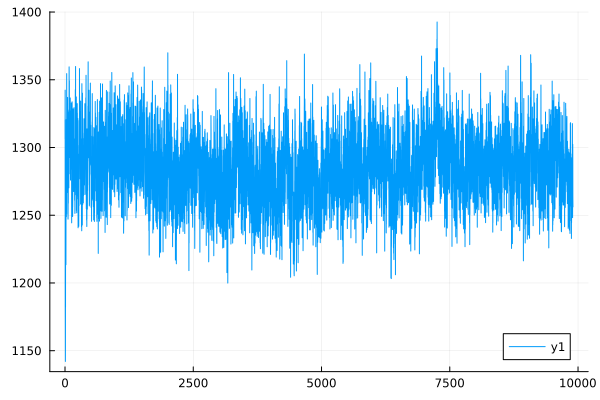

In [231]:
plot(E)

In [232]:
dE = [stats_chain[1][i][:hamiltonian_energy_error] for i in 100:10_000]
for n in 2:nchains
    dE = vcat(dE, [stats_chain[n][i][:hamiltonian_energy_error] for i in 1:1000])
end

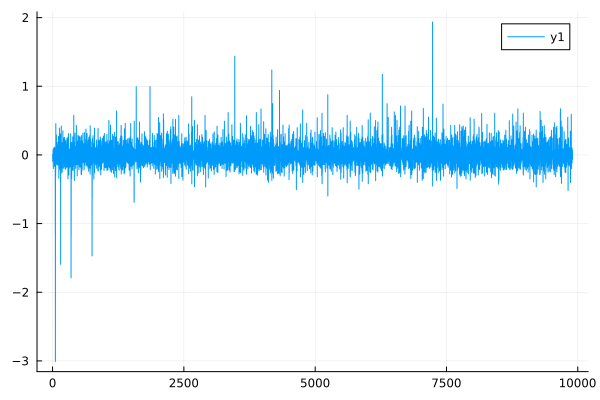

In [233]:
plot(dE)

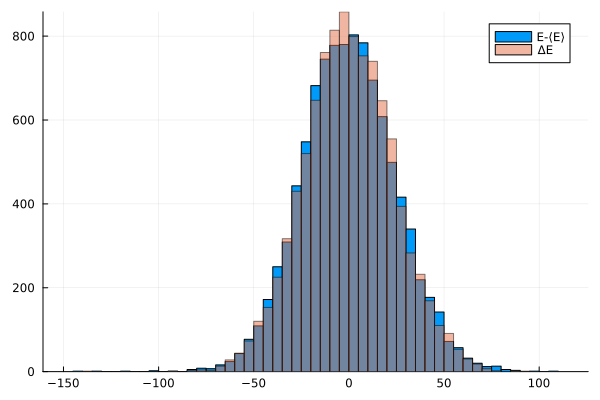

In [234]:
histogram(E.-mean(E), label="E-⟨E⟩")
ΔE =  E[2:end] .- E[1:(end-1)]
histogram!(ΔE, alpha=0.5, label="ΔE")

In [235]:
FMI = sum(ΔE.^2)/sum((E .- mean(E)).^2)

0.9305378022842592

In [414]:
j = 335

335

In [415]:
c = [sample_chain[1][i][j] for i in 10:10_000]
for n in 2:nchains
    c = vcat(c, [sample_chain[n][i][j] for i in 1:1000])
end

In [416]:
print(gen_θ[j], " , ", mean(c), " +- ", std(c))

0.6818400953927136 , 0.6808576114781026 +- 0.031423261376960984

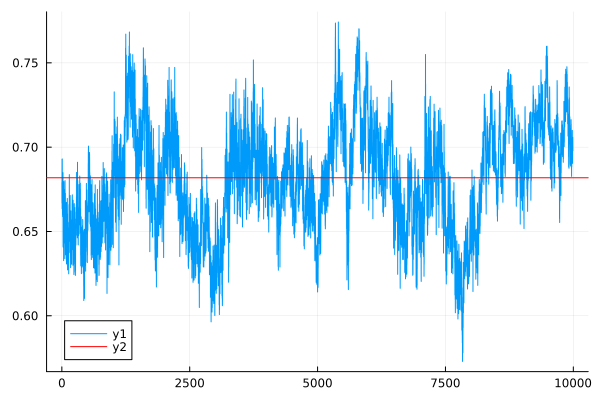

In [417]:
plot(c)
hline!([gen_θ[j]], color="red")

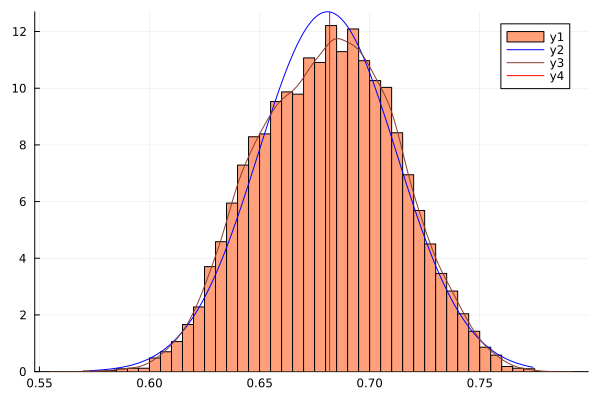

In [418]:
histogram(c, color="lightsalmon", normalize=:pdf)
x=range(minimum(c),maximum(c),1000)
plot!(x, pdf.(Normal(mean(c), std(c)), x), color="blue")
density!(c, color="coral4")
vline!([gen_θ[j]], color="red")

In [420]:
inf_k = mean(sample_chain[1])[513:end]
inf_k_err = std(sample_chain[1])[513:end];

inf_L = vector_from_k_to_L(inf_k, nbin, lmax, free_param_n);

inf_C = inf_L .* transpose.(inf_L);
err_C21 = inf_k_err[1:3:end];

In [421]:
ℓ = [i for i in 1:lmax+1];

In [422]:
gen_C = gen_L.*transpose.(gen_L);

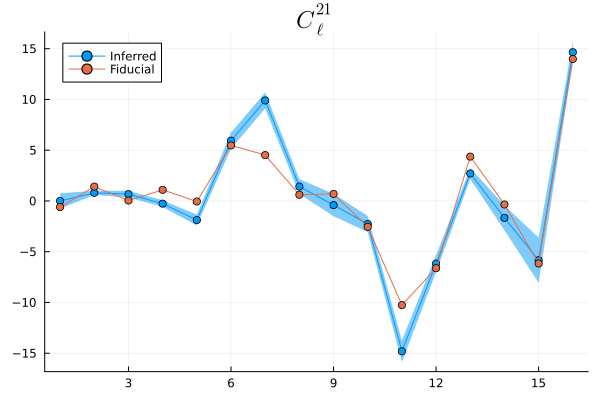

In [424]:
plot(ℓ, ℓ .* [inf_C[i][2,1] for i in 1:lmax+1], ribbon=ℓ .* err_C21, markershape=:circle, label="Inferred", plot_title=L"C_{\ell}^{21}")
plot!(ℓ, ℓ .* [gen_C[i][2,1] for i in 1:lmax+1], markershape=:circle, label="Fiducial")

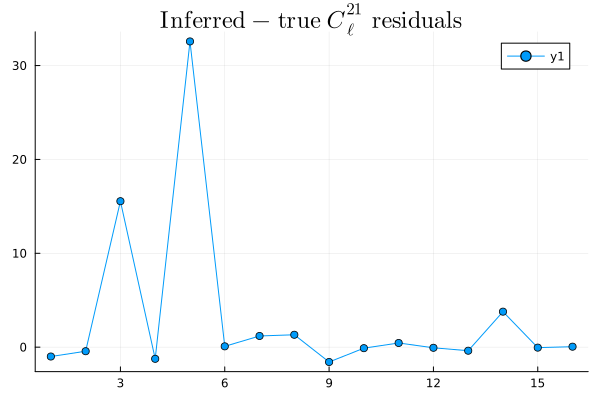

In [425]:
plot(ℓ[1:end], [(inf_C[i][2,1]-gen_C[i][2,1])/gen_C[i][2,1] for i in 1:lmax+1], markershape=:circle, 
    plot_title=L"\mathrm{Inferred-true} \ C_{\ell}^{21} \ \mathrm{residuals}")

# MCHMC

In [950]:
d = length(gen_θ)

560

In [951]:
function MCHMCℓπ(θ)
    return -neglogpost(θ)
end

function MCHMCℓπ_grad(x)
    f, df = withgradient(MCHMCℓπ, x)
    return f, df[1]
end

MCHMCℓπ_grad (generic function with 1 method)

In [952]:
target = CustomTarget(MCHMCℓπ, MCHMCℓπ_grad, gen_θ)

MicroCanonicalHMC.Target(560, MicroCanonicalHMC.Hamiltonian(MCHMCℓπ, MCHMCℓπ_grad), MicroCanonicalHMC.NoTransform, MicroCanonicalHMC.NoTransform, [0.4042778776383301, -2.373796357051546, 0.457681936685595, -2.508600800216199, 0.6861881166176884, -1.9062295860584408, -2.0995049723510646, 0.8766471314367783, 0.2553676133665055, -2.2140167230998835  …  -0.6312855715518011, 0.0, -1.4062828340646147, 0.969509812045706, 0.0, -1.049943837853233, -0.9367656143041845, 0.0, -0.33041475929166825, 0.6953971710621651], ["θ_1", "θ_2", "θ_3", "θ_4", "θ_5", "θ_6", "θ_7", "θ_8", "θ_9", "θ_10"  …  "θ_551", "θ_552", "θ_553", "θ_554", "θ_555", "θ_556", "θ_557", "θ_558", "θ_559", "θ_560"])

In [906]:
hyperparams = MicroCanonicalHMC.Hyperparameters() 
sett = Settings(nadapt=20_000, TEV=0.001, nchains=1, adaptive=true, integrator="MN",  init_eps=30., init_L=sqrt(d))
#sett = Settings(nadapt=1000, TEV=0.1., nchains=1, adaptive=true, integrator="MN",  init_eps=0.1, init_L=25.)
#sett = Settings(nadapt=1000, TEV=10., nchains=1, adaptive=true, integrator="LF",  init_eps=20., init_L=0.1)

Settings{Float64}(10000, 0.001, 1, true, "MN", 30.0, 23.664319132398465, nothing)

In [907]:
#hyperparams = MicroCanonicalHMC.Hyperparameters() 
#sett = Settings(nadapt=1000, TEV=0.00005, nchains=1, adaptive=true, integrator="MN", init_eps=0.5, init_L=1000.) # TEV=0.001 - TEV=0.00005

In [908]:
spl = MicroCanonicalHMC.MCHMCSampler(sett, hyperparams, MicroCanonicalHMC.Minimal_norm) #MicroCanonicalHMC.Leapfrog) 

MicroCanonicalHMC.MCHMCSampler(Settings{Float64}(10000, 0.001, 1, true, "MN", 30.0, 23.664319132398465, nothing), MicroCanonicalHMC.Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836, [0.0], 0.9607843137254902, 1.5), MicroCanonicalHMC.Minimal_norm)

In [909]:
samples_mchmc = Sample(spl, target, 10_000, init_params=gen_θ; dialog=true)

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
MCHMC (tuning):  20%|████████                           |  ETA: 0:07:29

Burn in step: 2000
eps --->0.00697363784000313
L   --->0.0019284868144514896
 


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:05:49

Burn in step: 4000
eps --->0.004248305772979904
L   --->0.0011307139017358054
 


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:04:03

Burn in step: 6000
eps --->0.00503948806284309
L   --->0.0011963045872593547
 


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:02:06

Burn in step: 8000
eps --->0.006387901631223061
L   --->0.0013899164452953218
 


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:10:54[ Info: eps: 0.006985813659517065
[ Info: L: 0.001428410734098548
[ Info: nu: 6.437095357644824
[ Info: sigma: [0.12316642365440639, 0.028954711369671576, 0.4239229411628621, 0.0310715006644342, 0.11174897081266714, 0.0669618239640082, 0.2361717191607433, 0.05939350070417644, 0.1811889414730927, 0.00878548558308614, 0.0790363523782999, 0.0350172114575293, 0.19472881324625502, 0.12387610145452056, 0.1473448693843725, 0.08912544881137617, 0.091602191983993, 0.17114693704271597, 0.2664535286602626, 0.03704375905399024, 0.13418953994798896, 0.0361945326812817, 0.19505236499940234, 0.033080217104286304, 0.1424354715606731, 0.034948823087333304, 0.20877491342893514, 0.04949197375572107, 0.5765783524286263, 0.03579834346352946, 0.6692864001647777, 0.07267457306889417, 0.036624753254216755, 0.09143901758847063, 0.4412908804976683, 0.0572675549845217, 0.2826689292031028, 0.08493524896121929, 0.19517386376020915, 0.17329601

Burn in step: 10000
eps --->0.006985813659517065
L   --->0.001428410734098548
 


2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:08:40

10000-element Vector{Any}:
 [0.7583839820455555, -0.4839518568151039, -0.34327212649344935, 0.7394530335518051, -1.1509253176787355, 0.6996457315158513, 0.5321400528936141, -0.1107849666315132, -0.4716198490955335, -1.6227788576792006  …  0.5121379496041382, -1.2172730919087444, -0.3536293869312376, 0.290445674062752, 0.15945628154910016, -1.3083046735160573, -1.0718483236790957, 0.006985813659517065, 2.4115523751825094, -3.5586249777646908e6]
 [0.7583602802174791, -0.4839447196139204, -0.3433253130081856, 0.7394523260794932, -1.151028533996724, 0.6996544710127203, 0.5321824834496778, -0.11077752501574928, -0.47161293009282734, -1.6227781167835924  …  0.5120418451757396, -1.2170941075428332, -0.35361785952297137, 0.2905025762773248, 0.15954443287947576, -1.3083058592868986, -1.0719952499631051, 0.00667356959455072, 2.2458405788056552, -3.5585398997196876e6]
 [0.7583668495959304, -0.48394734044953885, -0.3433298727443695, 0.7394472701514848, -1.1509907407425237, 0.6996323653739196, 0.53

In [910]:
summary = Summarize(samples_mchmc)

([20.640214787936333, 21.11349786353402, 20.67405964679249, 20.706392715040973, 20.690469655550856, 20.685720506203324, 20.740162266780658, 22.33796672921433, 20.65424719531258, 21.48031202598384  …  20.753563875354377, 20.661776845320375, 20.63525748734087, 20.670410406191152, 20.68577123483009, 20.67093656206422, 20.709599123063505, 719.5929822566368, 826.5422820992742, 20.661937936417647], [2.1222614423737958, 2.0148957348461543, 2.112844648455032, 2.122645128023618, 2.1226599871567258, 2.1226611301822693, 2.1226545578276976, 1.1902215052337284, 2.122444268327354, 1.8481591676166564  …  2.11255097651737, 2.1226682740974407, 2.1224159883073757, 2.122647699772785, 2.1223968429839615, 2.121533458471101, 2.1216701452088165, 1.0306188430354744, 1.0205023927279575, 2.1226685598553026])

In [911]:
ess, rhat = summary;

In [912]:
mean(ess)

23.746245644477877

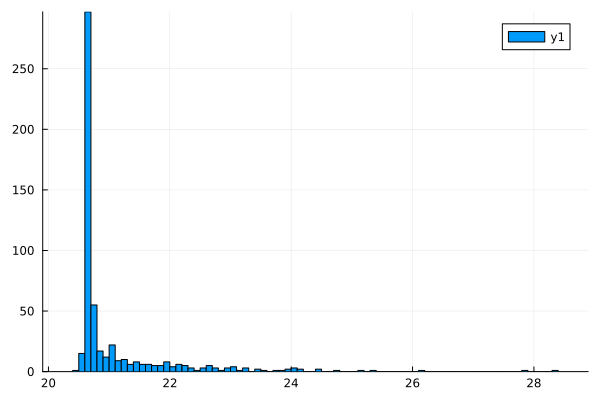

In [913]:
histogram(ess[1:544])

In [914]:
eps = [samples_mchmc[i][end-2] for i in 1:10_000];

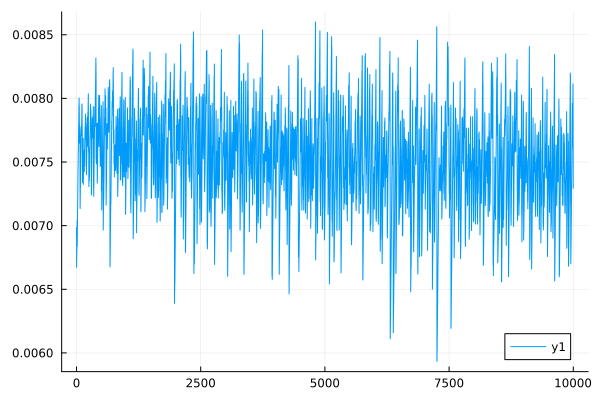

In [915]:
plot(eps)

In [916]:
dE = [samples_mchmc[i][end-1] for i in 1:10_000];

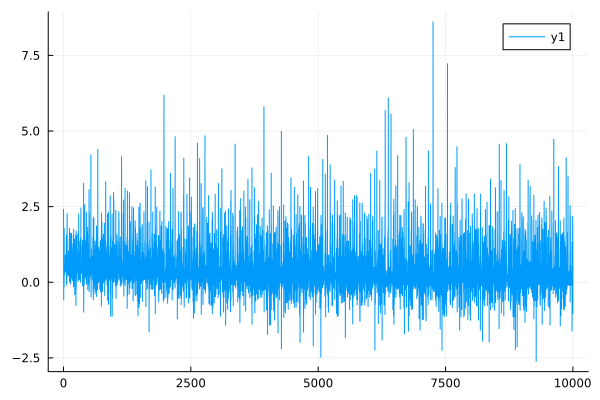

In [917]:
plot(dE)

In [932]:
j=338

338

In [933]:
c = [samples_mchmc[i][j] for i in 1:10_000];

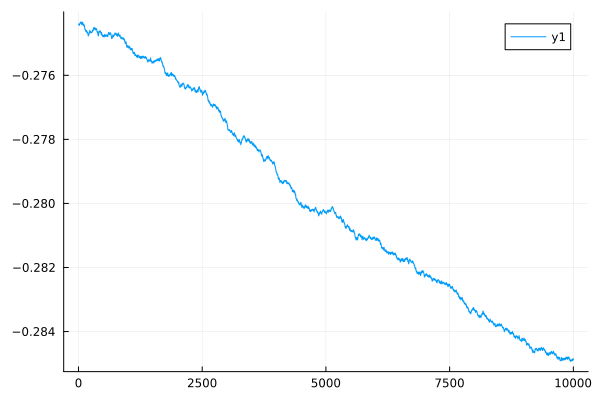

In [934]:
plot(c)
#hline!([gen_θ[j]], color="red")

In [928]:
gen_θ[j]

0.5984184460152155

In [935]:
inf_k = mean(samples_mchmc)[513:(end-3)]
inf_k_err = std(samples_mchmc)[513:(end-3)];

inf_L = vector_from_k_to_L(inf_k, nbin, lmax, free_param_n);

inf_C = inf_L .* transpose.(inf_L);
err_C21 = inf_k_err[1:3:end];

In [936]:
ℓ = [i for i in 1:lmax+1];

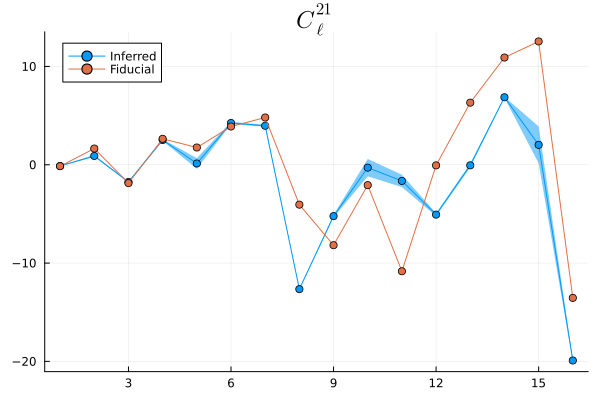

In [937]:
plot(ℓ, ℓ.*[inf_C[i][2,1] for i in 1:lmax+1], ribbon= ℓ.*err_C21, markershape=:circle, label="Inferred", plot_title=L"C_{\ell}^{21}")
plot!(ℓ, ℓ.*[gen_C[i][2,1] for i in 1:lmax+1], markershape=:circle, label="Fiducial")

## Testing

In [562]:
d = 100

100

In [563]:
C = Matrix(rand(LKJ(d, 1)))
inv_cov = inv(C)
m = 10 .* vec(rand(d,1)) .- 5.;

In [564]:
function neg_log_prob(q)
    return -0.5*((q-m)'*inv_cov*(q-m))
end

neg_log_prob (generic function with 1 method)

In [565]:
function testℓπ(x)
    return neg_log_prob(x)
end

function testℓπ_grad(x)
    f, df = withgradient(testℓπ, x)
    return f, df[1]
end

testℓπ_grad (generic function with 1 method)

In [515]:
q0 = rand(MvNormal(m,I));

In [523]:
target = CustomTarget(testℓπ, testℓπ_grad, q0)

MicroCanonicalHMC.Target(100, MicroCanonicalHMC.Hamiltonian(testℓπ, testℓπ_grad), MicroCanonicalHMC.NoTransform, MicroCanonicalHMC.NoTransform, [-0.22561061882151712, 2.7539795280517114, -3.4418235217721436, -0.07531475729895742, 4.9720530240140866, 3.075129451060014, -2.052379684447905, -1.854487312471053, 0.8804944664270304, 1.0069807214977036  …  -4.4265892102830655, 6.738154543527124, -0.21205359722801542, 3.524119190019205, -4.040908483438734, 3.3017279642590314, 0.3211902675118742, 0.1850245779252747, 2.1432616179810884, -2.9535134414144526], ["θ_1", "θ_2", "θ_3", "θ_4", "θ_5", "θ_6", "θ_7", "θ_8", "θ_9", "θ_10"  …  "θ_91", "θ_92", "θ_93", "θ_94", "θ_95", "θ_96", "θ_97", "θ_98", "θ_99", "θ_100"])

In [524]:
hyperparams = MicroCanonicalHMC.Hyperparameters(L=sqrt(d))
sett = Settings(nadapt=20_000, TEV=0.005, nchains=1, adaptive=true, integrator="LF", init_eps=0.05)#, init_L=sqrt(d))#  init_params=θ₀

Settings{Float64}(20000, 0.005, 1, true, "LF", 0.05, nothing, nothing)

In [526]:
spl = MicroCanonicalHMC.MCHMCSampler(sett, hyperparams, MicroCanonicalHMC.Leapfrog)

MicroCanonicalHMC.MCHMCSampler(Settings{Float64}(20000, 0.005, 1, true, "LF", 0.05, nothing, nothing), MicroCanonicalHMC.Hyperparameters{Float64}(0.0, 10.0, 0.0, 0.1931833275037836, [0.0], 0.9607843137254902, 1.5), MicroCanonicalHMC.Leapfrog)

In [527]:
samples_mchmc = Sample(spl, target, 10_000, init_params=m; dialog=true)

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:00:38

Burn in step: 4000
eps --->0.07743127458419871

MCHMC (tuning):  20%|████████                           |  ETA: 0:00:38

MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:47

Burn in step: 8000
eps --->0.1026103435182052


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:44

Burn in step: 12000
eps --->0.0656359765778078

MCHMC (tuning):  60%|██████████████████████             |  ETA: 0:00:44

MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:28

Burn in step: 16000
eps --->0.07235642330039145

MCHMC (tuning):  80%|█████████████████████████████      |  ETA: 0:00:28

2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:02:54

Burn in step: 20000
eps --->0.08241296894744507


[ Info: eps: 0.08241296894744507
[ Info: L: 10.0
[ Info: nu: 0.012891540305398883
[ Info: sigma: [1.0502696336569814, 1.1009490986477906, 1.0264765293368878, 1.1241058762212972, 1.0405888918193997, 1.009468298024998, 1.1255398252134197, 0.9241694856321575, 1.0442294579778295, 1.1434547402491693, 0.983653246444378, 0.9672739431540426, 0.9963548409428239, 1.016538077273735, 0.6802465118095293, 0.9130587055266216, 1.0628944007718302, 0.9424820155434426, 1.0059318451392532, 0.8495173920637965, 1.015717835743371, 0.9570036942259506, 0.9640140126784846, 0.8214571149794685, 1.005787072540348, 0.9081480737807852, 0.8370404341649851, 1.0690451113395167, 1.07310248513723, 0.8779235196976746, 0.8327418433876769, 1.033376123992254, 1.083808298422977, 0.7326111106389863, 0.8911292727270819, 1.0454150568369565, 0.9937631813408114, 0.8544488531510495, 0.9252529400653704, 0.9658517474005709, 1.058867055467498, 1.0688266660935906, 1.0341281983599346, 0.9668560220361961, 0.9112193938906924, 1.0215842129

10000-element Vector{Any}:
 [-0.5988779434545385, 3.336227295834655, -6.1728330114470085, -3.4450848064560833, 4.331653367869596, 5.311547087639035, -3.053406837400831, -2.0047087815546396, -2.273461250146041, 0.41567372830017  …  2.2321742879108215, -5.395865748085011, 3.814327808240363, -0.5259054127821129, 2.086725455344986, 3.527441455807937, -1.7397305934735279, 0.08241296894744507, -0.5385250203752534, -47.94417461594253]
 [-0.5904510791720654, 3.336040005082554, -6.183777100476577, -3.435334925959503, 4.34346989589388, 5.316237756928985, -3.056807842190692, -2.015835440074736, -2.280699625465936, 0.41304012620697245  …  2.2286827278973864, -5.395532865041022, 3.815225167163751, -0.5327607377121838, 2.084973883117887, 3.5163759176486966, -1.7332497491081709, 0.08196930735540492, 0.954819657336472, -50.65938650819729]
 [-0.5819255578766342, 3.332595395456296, -6.192640351803725, -3.4244159166377033, 4.3535964598605945, 5.319429991041441, -3.066040439837941, -2.0275643588120125, -2

In [535]:
s = [samples_mchmc[i][15] for i in 1:10_000];

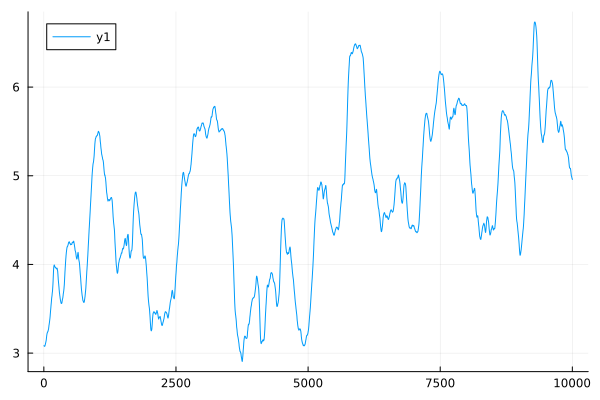

In [536]:
plot(s)

In [537]:
m[15]

4.01979392595247

In [566]:
@model function testprob(m,C)
    q ~ MvNormal(m, C)
end

testprob (generic function with 2 methods)

In [568]:
hyperparams = MicroCanonicalHMC.Hyperparameters(L=10.)
sett = Settings(nadapt=20_000, TEV=0.005, nchains=1, adaptive=true, integrator="LF", init_eps=0.05, init_L=10.)

Settings{Float64}(20000, 0.005, 1, true, "LF", 0.05, 10.0, nothing)

In [569]:
spl = MicroCanonicalHMC.MCHMCSampler(sett, hyperparams, MicroCanonicalHMC.Leapfrog)

MicroCanonicalHMC.MCHMCSampler(Settings{Float64}(20000, 0.005, 1, true, "LF", 0.05, 10.0, nothing), MicroCanonicalHMC.Hyperparameters{Float64}(0.0, 10.0, 0.0, 0.1931833275037836, [0.0], 0.9607843137254902, 1.5), MicroCanonicalHMC.Leapfrog)

In [570]:
samples_mchmc = sample(testprob(m,C), externalsampler(spl), 10_000)

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:02:34[ Info: eps: 0.23401262262114086
[ Info: L: 10.0
[ Info: nu: 0.021889506874865603
[ Info: sigma: [1.0810767328669444, 1.0340916073829862, 1.0280741296773757, 0.9057715089878262, 0.9849325060969928, 0.9618570566529041, 1.0345902885039326, 1.0734939716267136, 0.936730227315775, 1.0443822397782803, 0.9909847037389762, 1.0452591340191881, 0.9858487949419291, 0.9058609606465262, 1.18586218927529, 0.9911863185843349, 0.8691275148578852, 1.1254101932529614, 1.140570179718069, 0.9733899611621327, 0.9103346794320561, 1.0135058306303306, 0.9700316307186316, 0.9629948496510177, 0.8996501599608385, 1.0524701440958755, 1.0483056446403625, 1.0866518008750403, 1.0413112597496985, 1.0207002246882995, 1.1309914017185905, 1.0090077893625926, 1.0497508802660778, 1.005478003448274, 0.9736529022184288, 1.1567272344331248, 1.0193933563607696, 1.1166436945907354, 1.0249524085634725, 0.98610743

Chains MCMC chain (10000×101×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 201.84 seconds
Compute duration  = 201.84 seconds
parameters        = q[1], q[2], q[3], q[4], q[5], q[6], q[7], q[8], q[9], q[10], q[11], q[12], q[13], q[14], q[15], q[16], q[17], q[18], q[19], q[20], q[21], q[22], q[23], q[24], q[25], q[26], q[27], q[28], q[29], q[30], q[31], q[32], q[33], q[34], q[35], q[36], q[37], q[38], q[39], q[40], q[41], q[42], q[43], q[44], q[45], q[46], q[47], q[48], q[49], q[50], q[51], q[52], q[53], q[54], q[55], q[56], q[57], q[58], q[59], q[60], q[61], q[62], q[63], q[64], q[65], q[66], q[67], q[68], q[69], q[70], q[71], q[72], q[73], q[74], q[75], q[76], q[77], q[78], q[79], q[80], q[81], q[82], q[83], q[84], q[85], q[86], q[87], q[88], q[89], q[90], q[91], q[92], q[93], q[94], q[95], q[96], q[97], q[98], q[99], q[100]
internals         = lp

Summary Statistics
  parameters      mean       std      mcse   e

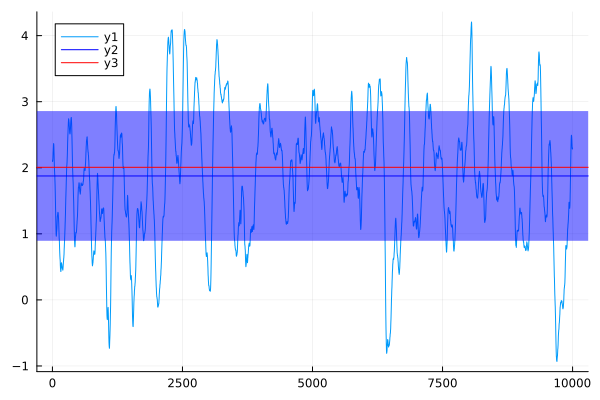

In [579]:
plot(samples_mchmc["q[55]"])
hline!([mean(samples_mchmc["q[55]"])], color="blue", ribbon=std(samples_mchmc["q[55]"]))
hline!([m[55]], color="red")

In [581]:
C[55,55]

1.0

In [582]:
m[55]

2.0073827377657514

# MUSE Inference

In [488]:
x₀ = gen_θ[1:nbin*(2*numberOfAlms(lmax)-(lmax+1))]
k₀ = gen_θ[nbin*(2*numberOfAlms(lmax)-(lmax+1))+1:end];

In [489]:
prob = SimpleMuseProblem(
    gen_maps,
    function sample_x_z(rng, θ)
        
        z = rand(rng, MvNormal(zeros(length(x₀)), I))
        
        L = vector_from_k_to_L(θ, nbin, lmax, free_param_n)
        Z = x_vec2vecmat(z, lmax, nbin)
        a = Chol_Lx2a(Z, L)
        alms = from_alm_to_healpix_alm(a, lmax, nbin)
        
        maps = alm2map.(alms, nside)

        x = constructor_VecHealpixMap(rand(rng, arraydist([MvNormal(maps[i], noise) for i in 1:length(maps)])))
        
        (;x, z)
    end,
    function logLike(x, z, θ)

        K = vectorK_vec2vecmat(θ, nbin, lmax, free_param_n)
        L = vector_from_k_to_L(θ, nbin, lmax, free_param_n)
        Z = x_vec2vecmat(z, lmax, nbin)
        a = Chol_Lx2a(Z, L)
        alms = from_alm_to_healpix_alm(a, lmax, nbin)

        loglike = -negloglikelihood(L, Z; maps=x)
        x_prior = -neglogprior1(z)-neglogprior2(K)

        return loglike+x_prior   
    end;
    autodiff = AbstractDifferentiation.ZygoteBackend()
)

SimpleMuseProblem{Vector{HealpixMap}, typeof(sample_x_z), typeof(logLike), MuseInference.var"#97#103"{AbstractDifferentiation.ReverseRuleConfigBackend{Zygote.ZygoteRuleConfig{Zygote.Context{false}}}, typeof(logLike)}, MuseInference.var"#102#108", MuseInference.var"#99#105"{AbstractDifferentiation.ReverseRuleConfigBackend{Zygote.ZygoteRuleConfig{Zygote.Context{false}}}, typeof(logLike)}, AbstractDifferentiation.ReverseRuleConfigBackend{Zygote.ZygoteRuleConfig{Zygote.Context{false}}}}(HealpixMap[[3.71166188165439, -0.5912020000229521, -0.5813466442366777, -0.1733955790161077, 7.028609302203386, 0.16510832385723406, -2.6254093076004197, 2.609834723402619, 3.687110110713265, -1.605632049615974  …  -6.5593440593032195, -7.133445971708916, -6.002556837122772, -0.7020949851939543, 3.7802050767032656, -4.380337842528396, -8.93211067137308, -8.19732706457303, -3.4609374382752227, -2.0967065975963033], [2.1723507572478513, 2.9548093055769367, 6.703864102830416, 7.71418882228475, -3.2729536804309

In [490]:
Random.seed!(3)
muse_result_manual = muse(prob, k₀; nsims=100, get_covariance=true, progress=true)# z₀=x₀, θ_rtol = 1e-4, ∇z_logLike_atol=1e-4, α=1e-4)

MUSE: 100%|█████████████████████████████████████████████| Time: 0:09:26m


LoadError: InterruptException:

In [ ]:
muse_result_manual.θ